importing the required packages and libraries.

In [1]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.models import Sequential, model_from_json


Using TensorFlow backend


Globale Variable

In [2]:
# Path
gv_path_models= "workspace/models/"
gv_path_images = "workspace/images/original_name/"
gv_annotation_path= "workspace/annotations/original/pascal/"
gv_model_path = "workspace/models/detector.h5"

SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0

The Dataset Preparation

In [3]:
main_class_ids=[
    #"Ausbildung",
    "Person" ,
    "Wohnsitz",
]
class_ids = [
"Ausbildung",
"Ausbildung_Klasse" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Antrag_gestellt_nein" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung" ,
"Ausbildung_Teilzeit" ,
"Ausbildung_Staette" ,
"Person" ,
"Person_Geburtsort" ,
"Person_maennlich" ,
"Person_Geburtsdatum" ,
"Person_weiblich",
"Person_divers",
"Person_Name",
"Person_Familienstand" ,
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
"Wohnsitz_Strasse",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Ort",
"Wohnsitz_waehrend_Ausbildung" ,
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Ort",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_nein",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_elternmiete",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_ja",
"Wohnsitz_waehrend_Ausbildung_elternmiete_nein"
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))
main_class_mapping = dict(zip(range(len(main_class_ids)), main_class_ids))

In [4]:
# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(gv_annotation_path, file_name)
        for file_name in os.listdir(gv_annotation_path)
        if file_name.endswith(".xml")
    ]
)
 
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(gv_path_images, file_name)
        for file_name in os.listdir(gv_path_images)
        if file_name.endswith(".jpg")
    ]
)

parsing the XML annotation files

In [5]:
def map_class_id(classes, cls):    
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return class_ids

def create_box(bbox):
    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)
    return [xmin, ymin, xmax, ymax]

In [6]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
 
    image_name = root.find("filename").text
    image_path = os.path.join(gv_path_images, image_name)

    boxes = []
    classes = []
    main_classes = []
    sub_classes = []
    main_boxes = []
    sub_boxes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
 
        bbox = obj.find("bndbox")
        boxes.append( create_box(bbox))
        #main labels
        #(cls=='Ausbildung') or
        if  (cls =='Person') or (cls == 'Wohnsitz'):
            main_classes.append(cls)
            bbox = obj.find("bndbox")
            main_boxes.append( create_box(bbox))
        else:
            bbox = obj.find("bndbox")
            sub_boxes.append( create_box(bbox))
            sub_classes.append(cls)

    class_ids = map_class_id(classes, cls)
    main_class_ids = map_class_id(main_classes, cls)            
    sub_class_ids = map_class_id(sub_classes, cls)

    return image_path, boxes, class_ids, main_class_ids, sub_class_ids, main_boxes, sub_boxes
 

In [7]:
image_paths = []
bbox = []
classes = []
main_classes = []
sub_classes= []
main_bbox= []
sub_bbox= []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids, main_class_ids,sub_class_ids, main_boxes, sub_boxes = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

    main_classes.append(main_class_ids)
    sub_classes.append(sub_class_ids)
    main_bbox.append(main_boxes)
    sub_bbox.append(sub_boxes)

  0%|          | 0/17 [00:00<?, ?it/s]

In [8]:
#TODO class id von main_class und suB_class müssn von 0 beginnen

In [9]:
def forming_main_class_labels(array):
    for i in range(len(array)):
        for j in range(len(array[i])):
           # if array[i][j] == 10:
               # array[i][j] = 0
            if array[i][j] == 11:
                array[i][j] = 0
            if array[i][j] == 28:
                array[i][j] = 1
    return array

def forming_sub_class_labels(array):
    for i in range(len(array)):
        for j in range(len(array[i])):
            #TODO Klasse Ausbildung 
            if array[i][j] > 28:
                array[i][j] = array[i][j]-1
            if (array[i][j] > 11) and (array[i][j] < 28):
               array[i][j] = array[i][j]-2
    return array

main_classes = forming_main_class_labels(main_classes)
print(sub_classes)
sub_classes = forming_sub_class_labels(sub_classes)
print((sub_classes))

[[0, 10, 1, 1, 17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35,

In [10]:
def create_data_tensor(image_paths,classes,bbox):
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)
    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
    return data

In [11]:
data = create_data_tensor(image_paths, classes, bbox)
main_data =create_data_tensor(image_paths, main_classes, main_bbox)
sub_data = create_data_tensor(image_paths, sub_classes, sub_bbox)

In [12]:
def create_train_test_data(split, data_tensor):
    num_val = int(split * SPLIT_RATIO)#int(len(image_path_list)
    val_data = data_tensor.take(num_val)
    train_data = data_tensor.skip(num_val)
    return val_data, train_data

In [13]:
val_data, train_data = create_train_test_data(int(len(xml_files)) , data)
main_val_data, main_train_data = create_train_test_data(int(len(xml_files)) , main_data)
sub_val_data, sub_train_data = create_train_test_data(int(len(xml_files)) , sub_data)

In [14]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image
 

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [15]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.75, 1.3),
            bounding_box_format="xyxy",
        ),
    ]
)

In [16]:
def create_train_ds(train_data):
    train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(BATCH_SIZE * 8)
    train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
    return train_ds

In [17]:
train_ds = create_train_ds(train_data)
main_train_ds = create_train_ds(main_train_data)
sub_train_ds = create_train_ds(sub_train_data)
print(main_train_ds)

<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(2, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([2, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([2, None, None]), tf.float32, 1, tf.int64)}}>


In [18]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

def create_val_ds(val_data):
    val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.shuffle(BATCH_SIZE * 8)
    val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
    return val_ds

In [19]:
val_ds = create_train_ds(val_data)
main_val_ds = create_train_ds(main_val_data)
sub_val_ds = create_train_ds(sub_val_data)

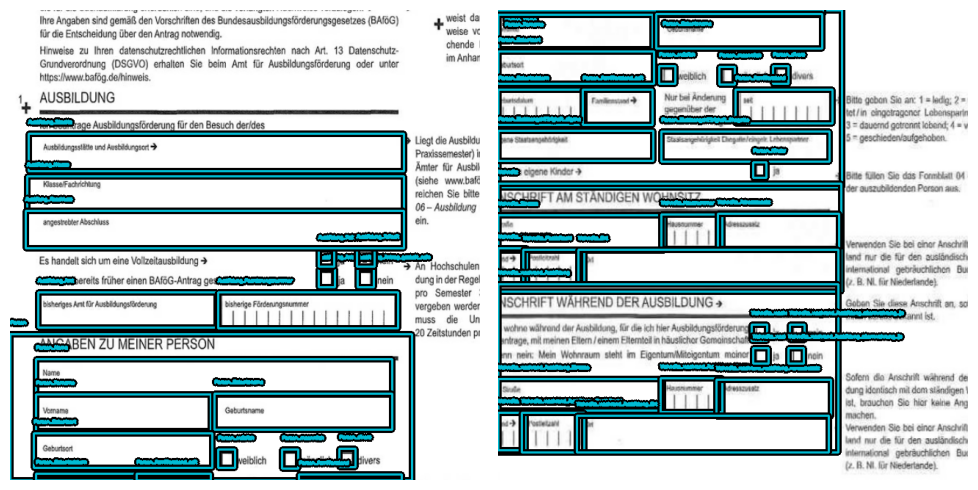

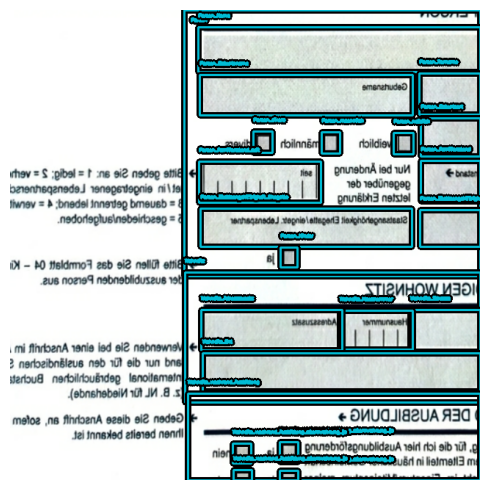

In [20]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.2,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )
 
 
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=2
)
 
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

In [21]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]
 
 
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
 
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

main_train_ds = main_train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
main_train_ds = main_train_ds.prefetch(tf.data.AUTOTUNE)
 
main_val_ds = main_val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
main_val_ds = main_val_ds.prefetch(tf.data.AUTOTUNE)

sub_train_ds = sub_train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
sub_train_ds = sub_train_ds.prefetch(tf.data.AUTOTUNE)
 
sub_val_ds = sub_val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
sub_val_ds = sub_val_ds.prefetch(tf.data.AUTOTUNE)

In [22]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
     # "yolo_v8_xs_backbone"
    "yolo_v8_xs_backbone_coco",
    # "yolo_v8_m_backbone"
     load_weights=True 
)
 
yolo_coco = keras_cv.models.YOLOV8Detector(
    num_classes=2,#len(class_mapping), #the number of object classes
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)
 
#yolo.summary()
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM, #This ensures that gradients, which influence the model’s parameter updates, 
                                    # don’t become exceedingly large and destabilize training.
)
 
yolo_coco.compile(
    optimizer=optimizer, 
    classification_loss="binary_crossentropy", #calculates the discrepancy between anticipated class probabilities and actual class probabilities
    box_loss="ciou" # box_loss -> measure the difference between the predicted bounding boxes and the ground truth
                    # he Complete IoU (CIoU) metric is used, which not only measures the overlap between predicted and ground truth bounding 
                    # boxes but also considers the difference in aspect ratio, center distance, and box size
)

In [23]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

In [25]:
"""
history_coco = yolo_coco.fit(
    main_train_ds,
    validation_data=main_val_ds,
    epochs=100
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "workspace/models/yolo_coco_model.h5")],
)
"""

'\nhistory_coco = yolo_coco.fit(\n    main_train_ds,\n    validation_data=main_val_ds,\n    epochs=100\n    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "workspace/models/yolo_coco_model.h5")],\n)\n'

TO-DO: try to save the trained model

In [26]:
SAVED_MODEL_PATH = gv_path_models +'/bbox/yolo_coco.h5'
model = yolo_coco
#model.save_weights(SAVED_MODEL_PATH)
model.load_weights(SAVED_MODEL_PATH)

load the save model and user it for prediction

visualize from train data

Filter bbox, 

In [35]:
yolo_coco.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.9,
    confidence_threshold=0.5
    
)

1/1 [==============================] - 3s 3s/step


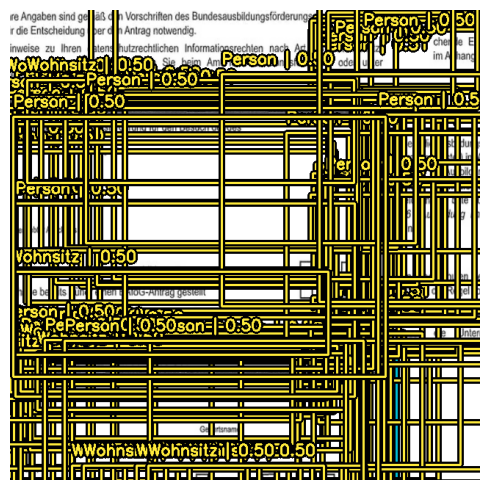

{'boxes': <tf.RaggedTensor [[[1.0562286, 475.466, 425.07068, 640.8431],
  [29.653076, 467.84708, 466.11627, 641.99615],
  [58.282227, 465.92578, 490.88306, 641.83264],
  [85.55365, 465.3241, 514.6337, 641.44214],
  [112.70186, 465.61902, 540.4011, 640.56586],
  [-48.380676, 476.37622, 393.741, 641.39764],
  [-17.513824, 461.29083, 452.1997, 623.03296],
  [144.58621, 467.137, 583.21533, 640.5278],
  [84.90837, 119.45105, 552.4796, 416.54565],
  [409.6717, 425.43057, 847.5301, 504.29623],
  [19.035797, 458.78268, 486.94415, 622.09656],
  [197.73387, 467.96985, 655.3101, 643.7447],
  [48.530624, 457.0149, 513.45264, 622.65845],
  [409.70157, 26.217014, 847.167, 103.099075],
  [518.5216, 164.32877, 792.5261, 833.42303],
  [78.03198, 456.0027, 540.40845, 621.6781],
  [-2.8954315, 475.0774, 428.7134, 586.0123],
  [56.113495, 123.565384, 525.36176, 409.79858],
  [84.7626, 110.39819, 583.9017, 453.601],
  [415.27405, 9.141678, 848.6942, 150.81819],
  [525.5887, -239.55466, 783.7721, 410.0514],

In [36]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=5,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=main_class_mapping,#class_mapping,
    )
    print(y_pred)
   
visualize_detections(yolo_coco, dataset=main_train_ds, bounding_box_format="xyxy")


predict from a path

1/1 [==============================] - 0s 68ms/step


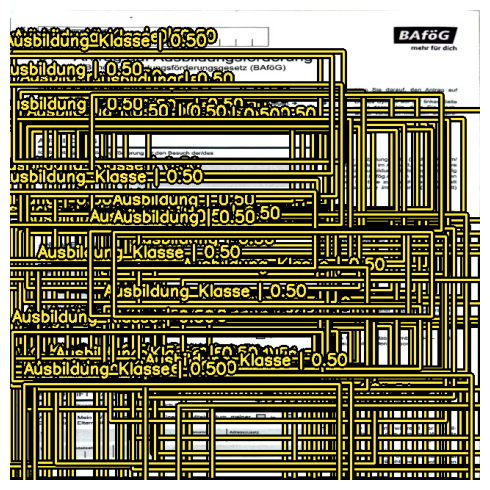

In [29]:
# Load and preprocess an example image (replace with your actual data loading code)
image_path = 'workspace/images/640x640/000000000003.jpeg'
image = tf.keras.utils.load_img(image_path)
image = tf.keras.utils.img_to_array(image)
image = tf.expand_dims(image, axis=0)  # Add batch dimension

# Make predictions
predictions = yolo_coco.predict(image)

predictions = bounding_box.to_ragged(predictions)
visualization.plot_bounding_box_gallery(
image,
value_range=(0, 255),
bounding_box_format='xyxy',
# y_true=y_true,
y_pred=predictions,
scale=5,
rows=1,
cols=1,
show=True,
font_scale=0.7,
class_mapping=class_mapping,
)



filter predicted data
save for every class only the best confidence

In [30]:
K=[]
i=0
f=[]
for row in predictions['classes'].values:
    j=0
    exsiting = False
    
    bb = predictions['boxes'].values.numpy()[i]
    
    xmin = bb[0]
    ymin = bb[1]
    xmax = bb[2]
    ymax = bb[3]
    
    w = xmax - xmin
    h = ymax - ymin
    A = w * h
    f.append(A)
    if A < 15428:

        for p in K:
            if p[1] == row.numpy():
                exsiting = True
                if p[2] < predictions['confidence'].values.numpy()[i]:
                    K[j][2] = predictions['confidence'].values.numpy()[i]
                    K[j][3] = predictions['boxes'].values.numpy()[i]
            j+=1
        
        if exsiting == False:
            K.append((i, row.numpy(), predictions['confidence'].values.numpy()[i], predictions['boxes'].values.numpy()[i] ))
     
    i+=1
f.sort()
print(f)

[28091.152, 36783.332, 39900.367, 40095.297, 41653.633, 43247.57, 43569.46, 43951.316, 44010.992, 44078.19, 44274.242, 44598.13, 44708.746, 44732.375, 47015.066, 47131.145, 47405.613, 48168.184, 49790.277, 49869.945, 50022.113, 55083.95, 55486.258, 55727.785, 58709.02, 59080.082, 59481.938, 63411.246, 64777.113, 65714.664, 66034.07, 66709.78, 67078.47, 67255.81, 68493.89, 69645.734, 69867.8, 70864.44, 71293.15, 72250.47, 72376.33, 72931.695, 73542.75, 74337.26, 74651.47, 74788.29, 76346.055, 77965.25, 78762.33, 82834.266, 83489.43, 84816.25, 88131.266, 88484.36, 88731.734, 89060.84, 89331.56, 89436.38, 89463.99, 89895.69, 90296.36, 90381.6, 90436.56, 90628.05, 90878.195, 90984.57, 91565.46, 92311.75, 93140.83, 93313.805, 93356.21, 94167.1, 94633.875, 94785.43, 95877.555, 96163.61, 96609.27, 98173.945, 98617.06, 98712.7, 98891.71, 98962.82, 99132.88, 99841.46, 100469.62, 100816.48, 101069.33, 101122.586, 102581.22, 102819.31, 103405.54, 104263.164, 110884.914, 112046.445, 114988.56, 123

save the bbox, classes and confidence in np array

In [31]:
confidence = []
boxes = []
classes = []
for s in K:
    boxes.append(s[3])
    confidence.append(s[2])
    classes.append(s[1])
    